# SGD with Mini Batch for Convolution Type MV-SDE

First of all, we import all the packages needed to use the mathematical functions of python.

In [8]:
import scipy
import math
import numpy as np
import matplotlib.pyplot as plt
import time
from numpy import linalg as LA
from numpy import mean
from tabulate import tabulate

The original MV-SDE is given as :

$$\textrm{d} X_t = \left. \mathbb{E}\left[\exp\left(-\cfrac{(X_t- x)^2}{2}\right)\right]\right|_{x=X_t}  \textrm{d} t +  \sigma \textrm{d} W_t, \quad X_0 = \mathcal{N}_{(0,1)}.$$

Note that above is of the form of equation (1.1) in Belomestny-Schoenmakers 2018. In paticular, we are interested in the approximation:
$$ \textrm{d} X_t = \sum^K_{k=0}\gamma_k(t) \alpha_k(X_t) \textrm{d} t +  \sigma \textrm{d} W_t, \quad X_0 = \mathcal{N}_{(0,1)}. $$
The above is of of the form of equation (2.3) in Belomestny-Schoenmakers 2018.

In the MV-SDE we see that:

* K = fixed parameter + 1, d = 1 e q = 1;
* $ \varphi_k(x) = \overline{H}_k(x) \mathrm{e}^{-x^2/2}, \hspace{1cm} \gamma_k(t) = \mathbb {E}[\varphi_k(X_t)], \hspace{1cm} \mbox{for } k = 0, \cdots, K$; 
* $ \alpha_k(x) = \pi^{1/4}\Bigl( \frac{1}{2}\Bigr)^{k/2} \frac{x^k}{\sqrt{k!}} \mathrm{e}^{-x^2/4}, \hspace{1cm} \mbox{for } k = 0, \cdots, K$; 
* $ \beta(x)=(\sigma, 0, \cdots, 0)^T $.

Also:

$$ \alpha'_k(x) = -\pi^{1/4}\Bigl( \frac{1}{2}\Bigr)^{k/2+1} \frac{x^{k-1}  (x^2-2k) }{\sqrt{k!}} \mathrm{e}^{-x^2/4}, \hspace{1cm} \mbox{for } k = 0, \cdots K. $$ 

In the above, $\overline{H}_k(x)$ are the normalised Hermite polynomials:

$$ \overline{H}_k(x) = c_k (-1)^k \mathrm{e}^{x^2} \frac{\mathrm{d}^k}{\mathrm{d} x^k} \bigl( \mathrm{e}^{-x^2}\bigr) =  c_k \mathrm{e}^{x^2/2} \left( x - \frac{\mathrm{d}}{\mathrm{d} x} \right) ^k \mathrm{e}^{-x^2/2}, \hspace{1cm} c_k = \bigl(2^k k! \sqrt{\pi} \bigr)^{-1/2}. $$

## Euler - Monte Carlo Method

Before showing the function that applies the Euler - Monte Carlo method, let us look at a couple of recursive functions that will be called.

In [9]:
def factorial(n):
    if n == 1:
        return [1, 1]
    else:
        return factorial(n-1)+[math.factorial(n)]
    
def exponential(K, x):
    if K == 1:
        return [x**0, x]
    else:
        return exponential(K-1,x)+[x**K] 
    
def exponential1(K, x):
    if K == 1:
        return [x, x**2 - 2]  
    else:
        return exponential1(K-1, x)+[x**(K-1) * (x**2 - 2*K)]
    
def alpha(K, M, x, f):
    return ( (( math.pi**(1/4) * (1/2)**(np.array(range(K+1))/2) ) * np.ones((M,1)) ).transpose() \
            * np.array(exponential(K, x)) \
            * ( ( np.array(f)**(-1/2) ) * np.ones((M,1)) ).transpose() \
            * np.exp(-(x**2)/4) * np.ones((K+1,1)) ) 
        
def alpha1(K, M, x, f):
    return ( - (( math.pi**(1/4) * (1/2)**(np.array(range(K+1))/2+1) ) * np.ones((M,1)) ).transpose() \
            * np.array(exponential1(K, x)) \
            * (( np.array(f)**(-1/2) ) * np.ones((M,1)) ).transpose() \
            * np.exp(-(x**2)/4) * np.ones((K+1,1)) ) 
        
def H(K, x, f):
    const = ( (2**K)**(-(1/2)) ) * ( f[K]**(-(1/2)) ) * ( (math.pi)**(-(1/4)) ) 
    if K == 1:
            return [( math.pi )**(-(1/4)) * np.ones((np.shape(x))), const * x]
    return H(K-1, x, f)+[const * (scipy.special.hermite(K, monic=False)(x))]

def phi1(K, x, f):
    const = ( (2**K)**(-(1/2)) ) * ( f[K]**(-(1/2)) ) * ( (math.pi)**(-(1/4)) )
    if K == 1:
            return [-(math.pi)**(-(1/4)) * x, math.sqrt(2)/(math.pi)**(1/4) * (1 - x**2)]
    return phi1(K-1, x, f)+[2 * K * const * (scipy.special.hermite(K-1, monic=False)(x)) - const * x * (scipy.special.hermite(K, monic=False)(x))]
    

In [10]:
def monte_carlo(sigma, T, N, M, K, f):
    h = T / N
    X = np.random.normal(0, 1, M)
    gamma = np.zeros((K+1, N+1))
    gamma[:,0] = mean( (np.array(H(K, X, f)) * np.exp(-((X ** 2)/2))), axis=1 )
    
    for i in range(N):
        W = np.random.normal(0, 1, M) 
        X = X + ( np.dot(gamma[:,i], alpha(K, M, X, f)) ) * h + sigma * math.sqrt(h) * W
        gamma[:,i+1] = mean( (np.array(H(K, X, f)) * np.exp(-((X ** 2)/2))), axis=1 )
    
    return X, gamma 

## Gradient Descend Method

### Euler for the simulation of $Z(\xi , W)$ and $\left( Z^a(\tilde{\xi} , \tilde{W}), \partial_{a_{h,j}} Z^a(\tilde{\xi} , \tilde{W}) \right)$

We define the two functions that allow us to simulate $Z(\xi , W)$ and $\left( Z^a(\tilde{\xi} , \tilde{W}), \partial_{a_{h,j}} Z^a(\tilde{\xi} , \tilde{W}) \right)$, i.e. the solutions of the system given by the following differential equations:

$$ dZ_t = \textbf{h} \left((\mathcal{L}a)(t)\right) \left( \alpha(t, Z_t)dt + \beta(t, Z_t)dW_t\right), \ \ \ Z_0 = \xi.$$

$$ dY^{j,k}_t = g_j(t) \nabla \textbf{h}_k \left((\mathcal{L}a)(t)\right) \left( \alpha(t, Z_t)dt + \beta(t, Z_t)dW_t\right) + \sum_{i=0}^d Y^{j,k,i}_t  \textbf{h} \left((\mathcal{L}a)(t)\right) \left( \partial_{z_i}\alpha(t, Z_t)dt + \partial_{z_i}\beta(t, Z_t)dW_t\right), \ \ \ \ Y^{j,k}_0 = 0,$$

for $j = 0, \cdots , n$ and $k = 1, \cdots, K$.

This function is used to create the base of the polynomial space. It takes in input the dimension $n$, the time $t$ in which the base vectors are to be calculated and the base type chosen. Returns a $n+1$ dimensional vector representing the base items calculated in $t$.

* canonical base:   $g_i(t):= t^i$ with equidistant knots;
* Lagrange's base: $g_i(t):=\prod_{j \leq n \ and  \ j\neq n} \left( \frac{t - t_j}{t_i - t_j} \right) $ with Chebyshev's knots: $\frac{a+b}{2} + \frac{b-a}{2} cos \left( \frac{2k + 1}{2n +2} \pi \right)$

In [11]:
def base(T, N, n, K, f, tipo):
    g = np.ones(n+1)
    cc = np.linspace(0, T, N+1)
    a = np.zeros((n+1, K+1)) 
    
    if tipo == 'canonical':
        g = np.array([ cc ** i for i in range(n+1)]) 
        
        a[0,0] = (math.pi)**(-(1/4))
        
        return a.transpose(), g
    
    elif tipo == 'lagrange':
        l = [(0 + T)/2 + (T - 0)/2 * np.cos(((2 * i + 1)/ (2 * n + 2)) * math.pi) for i in range(n+1)]
        
        g = np.array([math.prod([((cc - l[j]) / (l[i] - l[j])) for j in range(n+1) if j!=i]) for i in range(n+1)])
        
        a[:,0]= (math.pi)**(-(1/4))
        
        return a.transpose(), g 
        
    
    else:
        return 'err'
    
    
def base(T, N, n, K, f, tipo):
    g = np.ones(n+1)
    cc = np.linspace(0, T, N+1)
    a = np.zeros((n+1, K+1)) 
    X = np.random.normal(0, 1, 1)
    
    if tipo == 'canonical':
        g = np.array([ cc ** i for i in range(n+1)]) 
        
        a[0,:] = mean( (np.array(H(K, X, f)) * np.exp(-((X ** 2)/2))), axis=1 )
        
        return a.transpose(), g
    
    elif tipo == 'lagrange':
        l = [(0 + T)/2 + (T - 0)/2 * np.cos(((2 * i + 1)/ (2 * n + 2)) * math.pi) for i in range(n+1)]
        
        g = np.array([math.prod([((cc - l[j]) / (l[i] - l[j])) for j in range(n+1) if j!=i]) for i in range(n+1)])
        
        a[:,:]= mean( (np.array(H(K, X, f)) * np.exp(-((X ** 2)/2))), axis=1 )
        
        return a.transpose(), g 
        
    
    else:
        return 'err'

In this simplified algorithm the two maps $\textbf{h}$ and $ H $ are respectively the identity function and the null function. Considering the values of the coefficient functions for the convolution type MV-SDE, we have that the equations are:

$$ \mathrm{d} Z_t = \Big( (\mathcal{L}a)_0(t)\alpha_0(Z_t) + \cdots + (\mathcal{L}a)_K(t)\alpha_K(Z_t) \Big) \mathrm{d} t + \sigma \mathrm{d} W_t, \ \ \ Z_0 = \mathcal{N}_{(0,1)}. $$ 

$$ (\mathcal{L}a)_{l=0, \cdots , K}(t) = \sum^{n}_{i=1} a_{l,i} \prod_{\substack{ 1\leq j \leq n \\ i\neq j}} \frac{t-t_j}{t_i - t_j}. $$

The gradient processes $Y^{i, l}_t:= \partial_{a_{l,i}}Z_t, \mbox{ with } l=0, \cdots, K \mbox{ and } i = 1, \ldots, n,$ are given as:

$$ \begin{align}
\textrm{d}Y^{i,0}_t &= \bigl( \prod_{\substack{ 1\leq j \leq n \\ i\neq j}} \frac{t-t_j}{t_i - t_j} \alpha_0(Z_t) + (\mathcal{L}a)_0(t) \alpha^\prime_0(Z_t)  Y^{i,0}_t + \cdots + (\mathcal{L}a)_K(t) \alpha^\prime_K(Z_t)  Y^{i,0}_t\bigr) \textrm{d} t, \quad Y^{i,0}_0 = 0,\\
\vdots \\
\textrm{d}Y^{i,K}_t &= \bigl( \prod_{\substack{ 1\leq j \leq n \\ i\neq j}} \frac{t-t_j}{t_i - t_j} \alpha_K(Z_t) + (\mathcal{L}a)_0(t) \alpha^\prime_0(Z_t)  Y^{i,K}_t + \cdots + (\mathcal{L}a)_K(t) \alpha^\prime_K(Z_t)  Y^{i,K}_t\bigr) \textrm{d} t, \quad Y^{i,K}_0 = 0,\\
\end{align} $$


In [12]:
def euler(a, sigma, n, N, M, h, K, g, f):
    
    Z = np.zeros((N+1, M))
    Ztilde = np.zeros((N+1, M))
    Ytilde = np.zeros((n+1, K+1, N+1, M))
    Tensor = np.zeros((M, K+1, n+1))
    

    Z[0,:] = np.random.normal(0, 1, M) 
    Ztilde[0,:] = np.random.normal(0, 1, M)
 
    
    for i in range(N):
        c = np.dot(a, g[:,i])
        Tensor[:,:,:] = np.array(g[:,i])
        alphaZtilde = alpha(K, M, Ztilde[i], f)
        alpha1Ztilde = alpha1(K, M, Ztilde[i], f)
        
        W = np.random.normal(0, 1, (2, M)) 
    
        Z[i+1] = Z[i] + ( np.dot(c, alpha(K, M, Z[i], f)) ) * h + sigma * math.sqrt(h) * W[0]
        
        Ytilde[:,:,i+1,:] = Ytilde[:,:,i,:] + \
            ( Tensor.transpose() * ( alphaZtilde * np.ones((n+1, K+1, M)) ) + \
             ( (K+1) * mean( ( c * np.ones((M, 1)) ).transpose() * alpha1Ztilde, axis=0 ) ) * Ytilde[:,:,i,:] ) * h
        
        Ztilde[i+1] = Ztilde[i] + ( np.dot(c, alphaZtilde) ) * h + sigma * math.sqrt(h) * W[1]
        
    
    return Z, Ztilde, Ytilde

### Descent Method

In this section are the two most important functions of the code. The first is used to calculate the realisation of the gradient for stochastic descent, i.e. the function $v$. In general, the writing of $v$, component by component, is as follows:

$$v_{j,k}(a; \xi, W; \tilde{\xi}, \tilde{W}) = 2 \int_0^T \langle \varphi (Z^a_t(\xi,W)) - \textbf{h} ((\mathcal{L}a)(t)), \nabla_x \varphi (Z^a_t(\tilde{\xi}, \tilde{W})) Y_t^{a;j,k}(\tilde{\xi}, \tilde{W}) - \partial_{a_{j,k}}\textbf{h}((\mathcal{L}a)(t))\rangle dt, $$ 
with $j = 0, \cdots , n$ e $k = 0, \cdots, K$.

As in the previous cases, we write this e quation in the specific case of our algorithm. In particular, we have divided the time interval into N steps and therefore approximate the integral with a sum.

$$ v_{j,0}(a; W; \tilde{W}) = 2 h \sum_{t=0}^{N} \left[ \left( \varphi_0(Z^a_t(W)) - (\mathcal{L}a)_0(t) \right) \left( \varphi'_0(Z^a_t(\tilde{W})) Y^{j,0}_t(\tilde{W}) - g_j(t)\right) + \cdots + \left( \varphi_K(Z^a_t(W)) - (\mathcal{L}a)_K(t) \right)  \varphi'_K(Z^a_t(\tilde{W})) Y^{j,0}_t(\tilde{W}) \right], $$
$$ \vdots \\ $$
$$ v_{j,K}(a; W; \tilde{W}) = 2 h \sum_{t=0}^{N} \left[ \left( \varphi_0(Z^a_t(W)) - (\mathcal{L}a)_0(t) \right) \varphi'_0(Z^a_t(\tilde{W})) Y^{j,K}_t(\tilde{W}) + \cdots + \left( \varphi_K(Z^a_t(W)) - (\mathcal{L}a)_K(t) \right) \left( \varphi'_K(Z^a_t(\tilde{W})) Y^{j,K}_t(\tilde{W}) - g_j(t) \right) \right], $$

with $j = 0, \cdots, n$

We highlight that before returning the value $v$ this fuction averages it. This is in the case if $M>1$, where we exploit multiple simulations of the Brownian to get a better estimate of $v$.

$$ err = \frac{ \sum_{k,j} \left( (\gamma_{MC})_k(t_j)-(\gamma_{SGD})_k(t_j) \right)^2 }{\sum_k,j (\gamma_{MC})^2_k(t_j)}  $$


In [13]:
def stochastic_gradient_descent(a_0, n, r0, rho, sigma, N, M, K, eps, h, g, gamma, f, l):
    
    a = a_0 
    norm = LA.norm(gamma)
    
    for m in range(50000):
        
        if (m % l == 0):
            if (LA.norm( np.dot(a,g) - gamma ) / norm < eps) :
                break
            
        eta = r0 / ((m + 1) ** rho) 
        
        Z, Ztilde, Ytilde = euler(a, sigma, n, N, M, h, K, g, f) 
        
        primo = ( np.array(H(K, Z, f)) * np.exp(-((Z ** 2)/2)) ) - ( np.array([(np.dot(a[i], g) * np.ones((M,1))).transpose() for i in range(K+1)]) )
        secondo = np.zeros((K+1, K+1, N+1, M))
        Tensor = np.zeros((M, N+1, K+1, K+1))
        Tensor[:,:,:,:] = np.eye(K+1)
        Tensor = Tensor.transpose()
        v = np.zeros((K+1, n+1))
        
        for j in range(n+1):
            secondo[:,:,:,:] = ( np.array(phi1(K, Ztilde, f)) * np.exp(-((Ztilde ** 2)/2)) ) 
            secondo = secondo * Ytilde[j,:,:,:]
            terzo = np.swapaxes(secondo,0,1) - (g[j,:] * np.ones((M, 1))).transpose() * Tensor

            v[:,j] =  mean( 2 * h * (N+1) * mean ( (K+1) * mean(primo * terzo, axis = 1), axis = 1 ) , axis = 1)

        a = a - eta * v
        
    return m

## Main

Let us conclude by showing the main that calls the functions defined above. Let us recall what the values we will give as input to the functions we will call up correspond to:

* T : final istant,
* K : number of gamma function in the SDE
* $M_1$ : number of simulation for the MC,
* $N_1$ : time stes for the MC,
* N : time steps for the SGD,
* $\sigma$: constant diffusion,
* h : time step,
* $X_0$ : initial data,
* nnn : dimension of the polynomial space,
* $a_0$ : initial value of the SGD method vector,
* $r_0$ e $\rho$: learning rates constants. Must hold that: $r_0 \in (0, +\infty)$ and $\frac{1}{2} < \rho \leq 1$,
* m: number of iteration for the SGD method,
* M: Mini Batch between SGD and GD,
* $\epsilon$: 1% relative error tolerance,
* repetition: number of identical simulations we run for each parameter combination.

In [14]:
if __name__ == "__main__":
    
    # variable parameters
    
    T = 1
    N1 = 100
    N = 100
    K = 5   # 1, 5 ,10, 20
    sigma = 1
    nnn = [3]#[3, 4, 5, 6] 
    M1 = 100000
    M = [1, 10, 100, 1000]   # 10, 100, 1000, 10000
    h = T / N  
    l = [10, 10, 10, 1, 1]
    repetition = 10 
    r0 = [1, 5, 10]  
    rho = [0.6, 0.7, 0.8, 0.9]
    eps = 0.05
    

    # Euler - Monte Carlo
    
    f = factorial(K)
    
    start = time.process_time()   # the stopwatch starts
    X, gamma = monte_carlo(sigma, T, N1, M1, K, f)
    end = time.process_time()   # the stopwatch stops

    print("Euler - Monte Carlo execution time: ", end - start)
    print(" ")
    
            
    for n in nnn:
        
        # Gradient Descent
        
        a_0, g = base(T, N, n, K, f, 'lagrange')
        
        m = np.zeros((len(rho), len(r0)*3+1))
        m[:,0] = rho
        
        with open("times n = "+str(n)+".txt", "w") as F:
            
            for p in range(len(M)):
                F.write("Number of iterations to achieve convergence with M = "+str(M[p])+" :")
                F.write("\n")
                F.write("\n")

                for i in range(len(r0)):
                    for j in range(len(rho)):

                        start = time.process_time()   # the stopwatch starts
                        mm = [stochastic_gradient_descent(a_0, n, r0[i], rho[j], sigma, N, M[p], K, eps, h, g, gamma, f, l[p]) for u in range(repetition)] 
                        m[j,3*i+1:3*i+4] = [min(mm), max(mm), mean(mm)]
                        end = time.process_time()   # the stopwatch stops 

                        F.write("Execution time with r0="+str(r0[i])+" and rho="+str(rho[j])+": "+ str((end - start)/repetition))
                        F.write("\n")

                F.write("\n")
                F.write(tabulate(m[:,:], headers=[" rho \ r0", "1 (min)", "1 (max)", "1 (average)", "5 (min)", "5 (max)", "5 (average)", "10 (min)", "10 (max)", "10 (average)"]))
                F.write("\n")
                F.write("\n")
        
        print("done n = "+str(n))
                

Euler - Monte Carlo execution time:  37.953125
 


KeyboardInterrupt: 

IndexError: index 5 is out of bounds for axis 0 with size 2

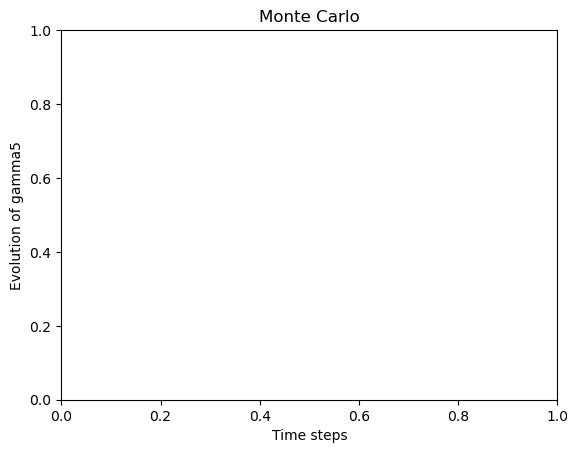

In [10]:
# Graphics 2
i = 5

fig = plt.figure() 
plt.title("Monte Carlo") 
plt.xlabel("Time steps") 
plt.ylabel("Evolution of gamma"+str(i)) 
plt.plot(gamma[i])

fig = plt.figure() 
plt.title("SGD") 
plt.xlabel("Time steps") 
plt.ylabel("Evolution (La)"+str(i)) 
plt.plot(np.dot(a, g)[i,:])

plt.show()

print(m)

### Draft function

In [ ]:
# def alpha(k, x):
#    return math.pi**(1/4) * (1/2)**(k/2) * ( (x**k)/(math.factorial(k)**(1/2)) ) * np.exp(-(x**2)/4) 

# def alpha1(k, x):
#    return - ( math.pi**(1/4) * (1/2)**(k/2+1) * np.exp(-(x**2)/4) * x**(k-1) * (x^2-2*k) ) / ( math.factorial(k)**(1/2) )

# def H(n, x):
#    return (  ( ( 2**n * math.factorial(n) * math.sqrt(math.pi) )**(-(1/2)) ) \
#            * math.factorial(n) \
#            * sum( [ ( ((-1)**m) * (x**(n-2*m)) ) / ( math.factorial(m) * math.factorial(n-2*m) * (2**m) ) for m in range(math.floor(n/2)+1) ] )  )

# def H(n, x):
#     if n % 2 == 0:
#         return math.factorial(n) * sum( [((-1)**(n/2-l)) / (math.factorial(2*l)*math.factorial(n//2 - l)) * ((2*x)**(2*l)) for l in range(n//2 + 1)] )
#     else:
#         return math.factorial(n) * sum( [((-1)**((n-1)/2-l)) / (math.factorial(2*l + 1)*math.factorial((n-1)//2 - l)) * ((2*x)**(2*l+1)) for l in range((n-1)//2 + 1)] )

# def c(k):
#     return ( 2 ** k * math.factorial(k) * math.sqrt(math.pi) )**(-(1/2))

# def monte_carlo(sigma, T, N, M, K):
#     h = T / N
#    X = np.random.normal(0, 1, M)
#    gamma = np.zeros((K+1, N1+1))
#    gamma[:,0] = [mean( H(k, X) * np.exp(-((X**2)/2)) ) for k in range(K+1)]
#    
#    for i in range(N):
#        W = np.random.normal(0, 1, M) 
#        X = X + sum( [gamma[k,i] * alpha(k,X) for k in range(K+1)] ) * h + sigma * math.sqrt(h) * W
#        gamma[:,i+1] = [mean( H(k, X) * np.exp(-((X**2)/2)) ) for k in range(K+1)]
#    
#    return X, gamma 

# def hh(n, x):
#     return (  ( (2**n)**(-(1/2)) ) * ( math.factorial(n)**(-(1/2)) ) * ( (math.sqrt(math.pi))**(-(1/2)) ) \
#             * math.factorial(n) \
#             * sum( [ ( ((-1)**m) * (x**(n-2*m)) ) / ( math.factorial(m) * math.factorial(n-2*m) * (2**m) ) for m in range(math.floor(n/2)+1) ] ) )  

# def H(K, M, x):
#     if K == 1:
#             return [hh(K, x), ( math.sqrt(math.pi) )**(-(1/2)) * np.ones((M))]
#     return H(K-1, M, x)+[hh(K, x)]

# def euler(a, sigma, n, N, M, h, K, g, f):
    
#     X = np.zeros((N+1, M))
#     Z = np.zeros((N+1, M))
#     Y = np.zeros((n+1, K+1, N+1, M))
    

#     X[0,:] = np.random.normal(0, 1, M) 
#     Z[0,:] = np.random.normal(0, 1, M)
 
    
#     for i in range(N):
#         c = np.dot(a, g[:,i])
#         alphaX = alpha(K, M, X[i], f)
#         alpha1X = alpha1(K, M, X[i], f)
        
#         W = np.random.normal(0, 1, (2, M)) 
    
#         X[i+1] = X[i] + ( np.dot(c, alphaX) ) * h + sigma * math.sqrt(h) * W[0]
        
#         for u in range(K+1):
#             Y[:,u,i+1,:] = Y[:,u,i,:] + ( (g[:,i] * np.ones((M, 1))).transpose() *  alphaX[u]  + ( (K+1) * mean((c * np.ones((M, 1))).transpose() * alpha1X, axis=0) ) * Y[:,u,i,:] ) * h
        
#         Z[i+1] = Z[i] + ( np.dot(c, alpha(K, M, Z[i], f)) ) * h + sigma * math.sqrt(h) * W[1]
        
    
#     return X, Z, Y

# def stochastic_gradient_descent(a_0, n, r0, rho, sigma, N, M, K, eps, h, g, gamma, f, l):
    
#     a = a_0 
#     norm = LA.norm(gamma)
    
#     for m in range(5000):
        
#         if (m % l == 0):
#             if (LA.norm( np.dot(a,g) - gamma ) / norm < eps) :
#                 break
            
#         eta = r0 / ((m + 1) ** rho) 
        
#         Z, Ztilde, Ytilde = euler(a, sigma, n, N, M, h, K, g, f) 
        
#         s = [(np.dot(a[i], g) * np.ones((M,1))).transpose() for i in range(K+1)]
#         ss = np.array(H(K, Z, f)) * np.exp(-((Z ** 2)/2))
#         sss = np.array(phi1(K, Ztilde, f)) * np.exp(-((Ztilde ** 2)/2))
#         v = np.zeros((K+1, n+1))
        
#         for u in range(K+1):
#             ssss = np.zeros((K+1, N+1, M))
            
#             for j in range(n+1):
#                 ssss[u] = (g[j,:] * np.ones((M, 1))).transpose() 
#                 v[u,j] = mean(2 * h * sum(sum( [ (ss[uu] - s[uu]) * (sss[uu] * Ytilde[j,u,:,:] - ssss[uu]) for uu in range(K+1) ] )) ) 

#         a = a - eta * v
        
#     return a, m

# def base(T, N, n, K, f, tipo):
#     g = np.ones(n+1)
#     cc = np.linspace(0, T, N+1)
#     a = np.zeros((n+1, K+1)) 
    
#     if tipo == 'canonical':
#         g = np.array([ cc ** i for i in range(n+1)]) 
        
#         a[0,0] = (math.pi)**(-(1/4))
        
#         return a.transpose(), g
    
#     elif tipo == 'lagrange':
#         l = [(0 + T)/2 + (T - 0)/2 * np.cos(((2 * i + 1)/ (2 * n + 2)) * math.pi) for i in range(n+1)]
        
#         g = np.array([math.prod([((cc - l[j]) / (l[i] - l[j])) for j in range(n+1) if j!=i]) for i in range(n+1)])
        
#         a[:,0]= (math.pi)**(-(1/4))
        
#         return a.transpose(), g 
        
    
#     else:
#         return 'err'